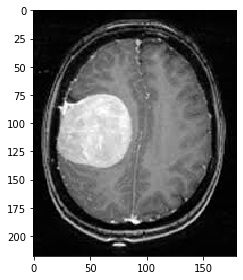

Area : 45.255950000000006cm2


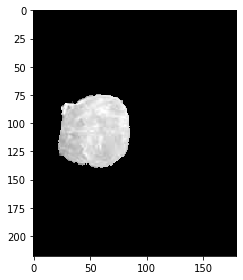

In [1]:
"""
Last name : TROUILLEZ
First name : Franck
Matricule : 000459766
Last update : 16/12/2020 18:14
"""

from skimage.io import imread, imshow, imsave
from skimage.color import hsv2rgb, rgb2hsv
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
from skimage.morphology import disk, erosion, watershed
import numpy as np
from skimage.filters.rank import gradient, median
from skimage.color import rgb2gray
from skimage.feature import peak_local_max
from skimage.measure import label
from scipy.ndimage import distance_transform_edt
%matplotlib inline

#############
### INPUT ###
#############

SOURCE_IMAGE = "mri_brain.jpg"
RESOLUTION_CM_PX = 0.115

SAVE_IMAGE = False #set to True to save the image
OUTPUT_IMAGE = "segmented_"+SOURCE_IMAGE #output file


##################
### PARAMETERS ###
##################

DISTANCE_THRESHOLD = 50 #minimal distance between a marker for the brain and the center of the mask corresponding to the tumour
GAMMA_FACTOR = 2 #gamma factor
DISK_RADIUS_EROSION = 20 #initial radius for the erosion of the mask
DISK_RADIUS_MEDIAN_FILTER = 3 #radius of the median filter when we use the gradient on the image
DISK_RADIUS_GRADIENT = 3 #radius of the gradient filter

#############################
### FUNCTIONS DEFINITIONS ###
#############################

def gammaCorrection(image, gamma):
    """
    Apply a gamma correction on a RGB image.
    """
    hsv_image = rgb2hsv(image)
    v_channel = (hsv_image[:,:,2].copy()*255).astype(np.uint8)
    A = 255**(1-gamma)
    lut = np.array([A*gin**gamma for gin in range(256)])
    v_channel = lut[v_channel]/255
    hsv_image[:,:,2] = v_channel
    new_image = (hsv2rgb(hsv_image)*255).astype(np.uint8)
    return new_image

def getDescriptors(region):
    """
    Get the descriptors for a region. In this case, return a color corresponding to the median of its channel on the region
    """
    return [np.median(region[:,0]), np.median(region[:,1]), np.median(region[:,2])]

def addMarker(markers, posY, posX, value):
    """
    Add a marker to the list at the position posY, posX with value "value"
    """
    markers[posY, posX] = value

def getCenterPos(mask):
    """
    Get the "center pos" of a mask. Return the furthest point from the mask borders
    """
    distance = distance_transform_edt(mask)
    result = np.unravel_index(np.argmax(distance, axis=None), distance.shape)
    return result

def distance(point1, point2):
    """
    Return the distance between 2 points
    """
    return np.sqrt(np.square(point1[0]-point2[0]) + np.square(point1[1]-point2[1]))

def getFarEnoughPos(mask):
    """
    Return a central position far enough from the center pos of the mask.
    """
    maskPos = getCenterPos(mask)
    centerPos = [mask.shape[0]//2, mask.shape[1]//2]
    #To know where our point has to go if it is too close to the mask, we have to know the relative position of the mask
    isLeft = True
    isTop = True
    if (maskPos[0] > centerPos[0]):
        isTop = False
    if (maskPos[1] > centerPos[1]):
        isLeft = False
        
    #Knowing the mask position, we know where we have to go
    stepY = 1
    stepX = 1
    if (not isTop):
        stepY = -1
    if (not isLeft):
        stepX = -1
    
    #While our point is too close from the mask, or include in the mask itself, it continues to move away
    currentPos = centerPos
    while (distance(currentPos, maskPos) < DISTANCE_THRESHOLD and mask[currentPos[0], currentPos[1]] == 1):
        currentPos[0] += stepY
        currentPos[1] += stepX
    return currentPos
    
def getImageDescriptors(im, mask) :
    """
    Get the image descriptors from an image. The markers are given by the mask. It uses the watershed method in order to get 
    the result
    """
    #We use the mask to get the labels
    markers, n = label(peak_local_max(mask, indices = False), return_num=True)
    
    #We add 2 markers
    #The first one is for the background
    addMarker(markers, 0, 0, n+1)
    #The second one is for the area inside the brain
    #We cant simply take the center of the image. If we have the case where the center is
    #in the tumor, we have a problem. That's why we handle this by taking a point in the center, but far away from the mask
    #describing the tumour position
    centerPos = getFarEnoughPos(mask)
    addMarker(markers, centerPos[0], centerPos[1], n+1)
    
    #Then, we take the gradient and we apply the watershed method
    grad = gradient(median((rgb2gray(im)*255).astype(np.uint8), disk(DISK_RADIUS_MEDIAN_FILTER)), disk(DISK_RADIUS_GRADIENT))
    ws = watershed(grad, markers)
    
    #And we build our image descriptors
    descriptors = np.zeros((ws.max()+1, 3))
    im_descriptors = np.zeros_like(im)
    
    for i in range(ws.min(), ws.max()+1):
        descriptors[i] = getDescriptors(im[ws==i])
        im_descriptors[ws==i] = descriptors[i]
    
    #We ensure that the lowest value is 0 (because it should include the background, which has a value of 0)
    minValue = im_descriptors.min()
    im_descriptors[im_descriptors == minValue] = 0
        
    return im_descriptors

def getMinimalMask(mask):
    """
    Return an eroded version of the mask given in input where there exists at least one point different than 0
    """
    erosion_radius = DISK_RADIUS_EROSION
    new_mask = erosion(mask, disk(erosion_radius))
    #While there is no pixel with value 1, we try to erode with a smaller radius
    while ((new_mask==1).sum() == 0):
        erosion_radius -= 1
        new_mask = erosion(mask, disk(erosion_radius))
    return new_mask

def segmentTumor(im, resolution):
    """
    Return a segmented image showing the tumour only. Return also the surface of the tumour based on the 
    resolution given in input
    """
    new_im = im.copy()
    
    #First, we apply a gamma correction, in order to further highlight the tumour
    new_im = gammaCorrection(new_im, GAMMA_FACTOR)
    
    #Then, we apply an Otsu threshold on the value channel of the HSV version of the image.
    #It gives us a mask which includes the tumour, but also maybe the skull and bones, which are very bright too
    hsv_im = hsv2rgb(new_im)
    v_im = hsv_im[:,:,2]
    threshold = threshold_otsu(v_im)
    mask = v_im > threshold
    
    #In order to fix that, we will get an eroded version of the mask
    #Knowing that a tumour looks more like a disk, and that the bones looks like lines, the eroded version of
    #the mask will only contains points inside the tumor. Indeed, the erosion is more effective on lines than on disk shapes.
    mask = getMinimalMask(mask)
    #We can now get the image descriptors of the image using the points in the eroded masks as markers
    new_im = getImageDescriptors(new_im, mask)
    
    #Once we get the images descriptors, we can once again apply an Otsu threshold in order to get the tumour
    hsv_im = hsv2rgb(new_im)
    v_im = hsv_im[:,:,2]
    threshold = threshold_otsu(v_im)
    mask = v_im > threshold
    
    #We calculate the surface of the tumour
    area = mask.sum()*resolution*resolution
    
    #We apply the final mask on the image
    resultImage = im.copy()
    for color in range(3) :
        resultImage[:,:,color] = resultImage[:,:,color]*mask
    
    return resultImage, area


######################
### MAIN EXECUTION ###
######################


try:
    #Source image
    im = imread(SOURCE_IMAGE)

    #Segmented image
    segmentedImage, area = segmentTumor(im, RESOLUTION_CM_PX)

    #Show source image
    plt.figure()
    imshow(im)
    plt.show()

    #Output the area of the tumour
    print("Area : "+str(area)+"cm2")
    
    #Show the segmented image
    plt.figure()
    imshow(segmentedImage)
    plt.show()
    
    if SAVE_IMAGE:
        imsave(OUTPUT_IMAGE, segmentedImage)
    
except FileNotFoundError:
    print("Error, the file is not found")
except:
    print("Unexpected error during the execution")
    raise